# Mustererkennung/Machine Learning - Assignment 9



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline

# Excercise  Solution: Multilayer-Perceptron (MLP) with Backpropogation

#### Splitting the data into training/test and according to their class memberships

/home/suresh/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


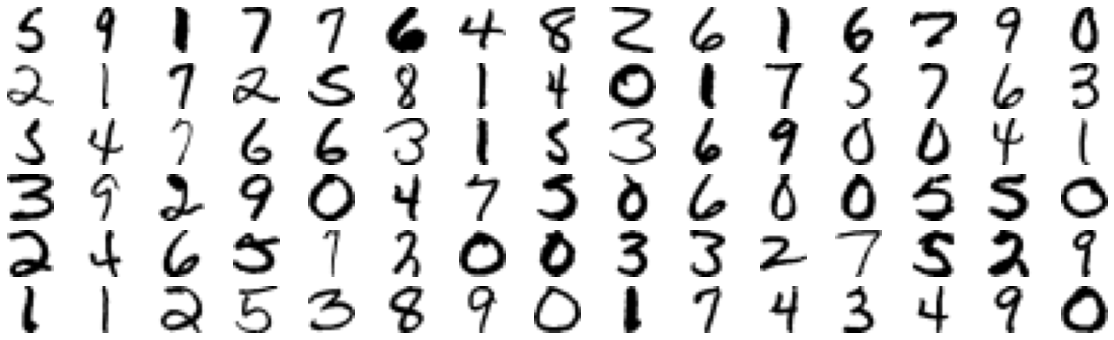

In [2]:
training_data = np.array(pd.read_csv('zip.train', sep=' ', header=None),dtype=np.float128)
test_data = np.array(pd.read_csv('zip.test', sep =' ',header=None),dtype=np.float128)

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 255 - sample_digits[i].reshape((16, 16))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
show_numbers(X_train)

In [3]:
#y_labels in form of vector  for digits for multiclass
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
#print( X_train)

In [4]:
#Data Normalization/standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [5]:
class Sigmoid:
    def activation(z):
        return 1 / (1 + np.exp(-z))
    def gradient(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
class Relu:
    def activation(z):
        z[z < 0] = 0
        return z
    def gradient(x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
class softmax:
    def activation(Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
class Multilayer_perceptron:
    def __init__(self, total_layer=2,dimensions=None, activations=None, learning_rate=0.1):
        """
        parameters
        1. total_layer: no of layers including input layer, hidden layers and output layer
        2. dimensions: Dimensions of the neural net. (no of input, no of nodes in hidden layer, no of neuron in  output)
        3. activations:Activations functions for each layer.
        4. learning_rate: learning 

        """

        self.n_layers = total_layer
        self.loss = None
        self.learning_rate = learning_rate
        self.sizes=dimensions

        # Weights and biases are initiated by index. For a one hidden layer net you will have a w[1] and w[2]
        self.w = {}
        self.b = {}

        # Activations are also initiated by index. For the example we will have activations[2] and activations[3]
        self.activations = {}

        for i in range(len(dimensions) - 1):
            #self.w[i + 1] = np.ones((dimensions[i+1], dimensions[i]))
            limit   = 1 / np.sqrt(dimensions[i])
            self.w[i + 1] = np.random.uniform(-limit, limit,(dimensions[i+1], dimensions[i]) )
            self.b[i + 1] = np.zeros((dimensions[i + 1],1))
            self.activations[i + 2] = activations[i]
            
    def _feed_forward(self, x):
        """
        Execute a forward feed through the network.

         x:input data vectors.
        return:  Node outputs and activations per layer. 
                 The numbering of the output is equivalent to the layer numbers.
        """

        # w(x) + b
        z = {}

        # activations: f(z)
        a = {1: x.T}  # First layer has no activations as input. The input x is the input.

        for i in range(1, self.n_layers):
            # current layer = i
            # activation layer = i + 1
            #print(np.dot( self.w[i],a[i]))
            z[i + 1] = np.dot( self.w[i],a[i]) + self.b[i]
            #print(z[i+1])
            a[i + 1] = self.activations[i + 1].activation(z[i + 1])
            #print(a[i+1])
        #print(z,a)
        return z, a
    #backpropogation function  
    def back_propogation(self, x, y):
        self.Z,self.A=self._feed_forward(x)
        self.dW = {}
        self.dB = {}
        self.dZ = {}
        self.dA = {}
        L = self.n_layers
        #print(self.A[L],self.A[L].shape)
        #print(y,y.shape)
        #gradient of error in respect of z  and z=wx+b
        self.dZ[L] = (self.A[L] - y.T)
        #print(self.A[L],y,self.dZ[L])
        for k in range(L, 1, -1):
          #previous value in chain rule
          delta=np.dot(self.w[k-1].T,self.dZ[k])
          #print('iter',k)
          #self.A[k-1]=np.array(self.A[k-1]).reshape(self.A[k-1].shape[0],1)
          self.dW[k-1] = np.dot(self.dZ[k],self.A[k-1].T)*(1/self.total_samples)
          #print('dw',self.dW[k-1])
          self.dB[k-1] = np.sum(self.dZ[k], axis=1, keepdims=True)*(1/self.total_samples)
          #print('dB',self.dB[k-1])
          # assuming activation function start from in between 1st layer and 2nd layer so a1=X, a2=activation , a3=activation, an=output activation
          if(k>2):
              self.dZ[k-1] = delta*self.activations[k-1].gradient(self.A[k-1])
    
    def fit(self, X, Y, epochs=100, display_loss=True,test_data=None):

        if display_loss:
          loss = {}
          train_acc={}
          test_acc={}
        self.total_samples = X.shape[0]
        for epoch in range(epochs):
          dW = {}
          dB = {}
          for i in range(self.n_layers - 1):
            dW[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
            dB[i+1] = np.zeros((self.sizes[i+1],1))
          #for x, y in zip(X, Y):
          X,Y=self.shuffle_data(X, Y)
          self.back_propogation(X, Y)
          for i in range(self.n_layers-1):
              dW[i+1] += self.dW[i+1]
              dB[i+1] += self.dB[i+1]

          
          #print(total_samples)
          for i in range(self.n_layers-1):
            #self.b[i+1]=self.b[i+1].reshape(1,-1)
            #print(dB[i+1].shape)
            self.w[i+1] -= self.learning_rate * dW[i+1]
            self.b[i+1] -= self.learning_rate * dB[i+1]

          if display_loss:
            #Y_pred = self.predict(X) 
            loss[epoch] = self.cross_entropy(Y)
            train_acc[epoch]=self.accuracy(X,Y)
            test_acc[epoch]=self.accuracy(test_data[0],test_data[1])
            if epoch%500==0:
                print("epoch",epoch,'loss:',loss[epoch],' Training Accuracy:',train_acc[epoch]*100,' Test Accuracy:',test_acc[epoch]*100)
        #loss plot
        if display_loss:
           self.plot_loss_acc([loss,(train_acc,test_acc)])
          
    #prediction method
    def predict(self, X):
        lin_sum,output = self._feed_forward(X)
        return output[self.n_layers]
    #cross entropy calculation function
    def cross_entropy(self,Y):
        return  -np.mean(Y * np.log(self.A[self.n_layers].T))
    def accuracy(self,X,Y):
        Y_pred_test = self.predict(X)
        Y_pred_test = np.argmax(Y_pred_test.T,1)
        Y = np.argmax(Y, axis=1)
        return accuracy_score(Y_pred_test, Y)
    def plot_loss_acc(self,data):
        fig, axs = plt.subplots(1,2,figsize=(15, 10))
        y_label=['loss','Training Accuracy','Test Accuracy']
        for kk, (ax,yy) in enumerate(zip(axs.reshape(-1),data)):
            if(kk==1):
                ax.plot(yy[0].values(),label=y_label[kk])
                ax.plot(yy[1].values(), label=y_label[kk+1])
                ax.legend(loc='upper left')
                ax.set(xlabel='Epochs', ylabel='accuracy')
            else:
                ax.plot(yy.values())
                ax.set(xlabel='Epochs', ylabel=y_label[kk])
        #fig.delaxes(axs[1][1])
        plt.show()
    def shuffle_data(self,X, y, seed=None):
        """ Random shuffle of the samples in X and y """
        if seed:
            np.random.seed(seed)
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        return X[idx], y[idx]

        

# (a) Optimize width (the number of neurons in a hidden layer; it is usually the same for all of them) and depth of the network. Try to find a setting that trains in a reasonable time. Plot the loss.
Answer: We tried with different architecture of  neural network like number of layers , and number of neurons in each layer, however we found best results with 1 layer having 16 neurons with sigmoid activation function(hidden layer) and softmax activation function(output layer).

# Neural Network Architecture 1: Hidden Layer=1, 16 neurons, Sigmoid (hidden layer), Softmax(output layer)

In [6]:

#dimenstions=(nodes_inputlayer,nodes_hidden_layer1,nodes_hidden_layer2, ....., nodes_hidden_layern,nodes_output_layer)
dimenstions=(X_train.shape[1], 16, len(np.unique(y_train)))
#activations=(activation_function_of_hidden_layer1,activation_function_of_hidden_layer2, ...., activation_function_of_output_layer )
activations_funct_list= ( Sigmoid, softmax)
mlp = Multilayer_perceptron(total_layer=len(dimenstions),dimensions=dimenstions, activations= activations_funct_list,learning_rate=0.1)

epoch 0 loss: 0.23562771682995468  Training Accuracy: 8.942531888629818  Test Accuracy: 9.965122072745391
epoch 500 loss: 0.05384783461759707  Training Accuracy: 87.4365656288575  Test Accuracy: 82.31190832087692
epoch 1000 loss: 0.03781895325598989  Training Accuracy: 90.0562337127966  Test Accuracy: 85.74987543597409
epoch 1500 loss: 0.03241690274253408  Training Accuracy: 91.09861473048964  Test Accuracy: 86.49725959143
epoch 2000 loss: 0.029522470578699153  Training Accuracy: 91.88040049375942  Test Accuracy: 87.045341305431
epoch 2500 loss: 0.02760746927816763  Training Accuracy: 92.19585790700864  Test Accuracy: 86.84603886397608
epoch 3000 loss: 0.026245943241190728  Training Accuracy: 92.47016870113839  Test Accuracy: 87.593423019432
epoch 3500 loss: 0.025194061015126994  Training Accuracy: 92.90906597174599  Test Accuracy: 87.7927254608869
epoch 4000 loss: 0.024309079102481233  Training Accuracy: 93.21080784528871  Test Accuracy: 88.09167912306926
epoch 4500 loss: 0.0235870182

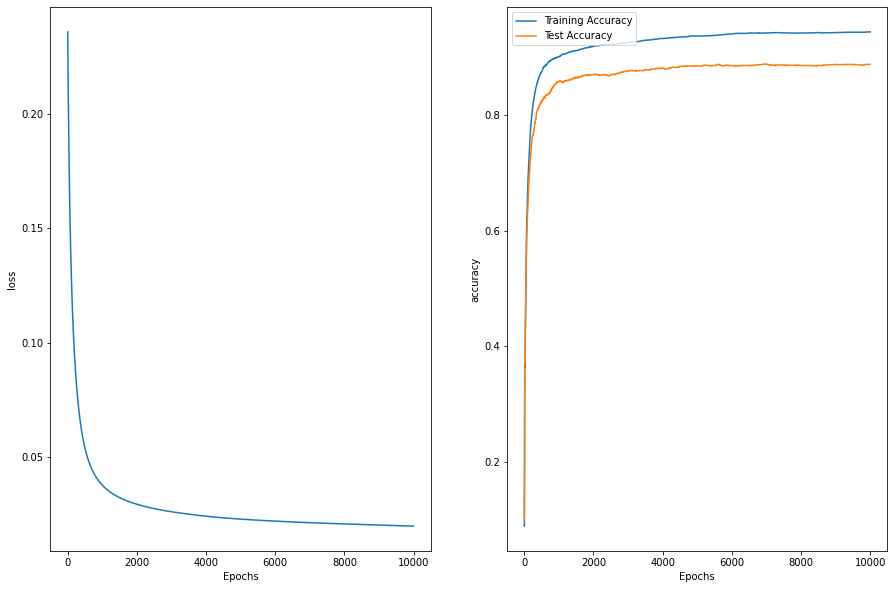

In [7]:
mlp.fit( X_train,y_OH_train, epochs=10000, display_loss=True,test_data=(X_test,y_OH_test))

In [8]:
import sklearn
Y_pred_train = mlp.predict(X_train)
print(Y_pred_train.T.shape)
Y_pred_train = np.argmax(Y_pred_train.T,1)

Y_pred_test = mlp.predict(X_test)
Y_pred_test = np.argmax(Y_pred_test.T,1)

print(Y_pred_train.shape,y_train.shape)
accuracy_train = accuracy_score(Y_pred_train, y_train)
accuracy_test = accuracy_score(Y_pred_test, y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Test Dataset accuracy", round(accuracy_test, 2))
print(sklearn.metrics.classification_report(y_test, Y_pred_test))


(7291, 10)
(7291,) (7291,)
Training accuracy 0.94
Test Dataset accuracy 0.89
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       359
         1.0       0.97      0.94      0.96       264
         2.0       0.84      0.85      0.85       198
         3.0       0.86      0.88      0.87       166
         4.0       0.79      0.86      0.82       200
         5.0       0.86      0.80      0.83       160
         6.0       0.91      0.89      0.90       170
         7.0       0.88      0.89      0.89       147
         8.0       0.89      0.79      0.84       166
         9.0       0.88      0.89      0.89       177

    accuracy                           0.89      2007
   macro avg       0.88      0.88      0.88      2007
weighted avg       0.89      0.89      0.89      2007



# Neural Network Architecture 2:  Hidden Layer=2, neurons in each hidden layer=16, Sigmoid Activation (hidden layer), Softmax(output layer)

epoch 0 loss: 0.23234757232659572  Training Accuracy: 8.846523110684405  Test Accuracy: 7.324364723467862
epoch 500 loss: 0.14044484565345697  Training Accuracy: 54.99931422301467  Test Accuracy: 51.569506726457405


<ipython-input-5-9b9c8a1fb92a>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


epoch 1000 loss: 0.11140425427928147  Training Accuracy: 63.585242079275815  Test Accuracy: 59.342301943198805
epoch 1500 loss: 0.09194209466151916  Training Accuracy: 70.18241667809629  Test Accuracy: 65.6203288490284
epoch 2000 loss: 0.08030490178296298  Training Accuracy: 74.9828555753669  Test Accuracy: 70.95166915794718
epoch 2500 loss: 0.07126757089183525  Training Accuracy: 79.44040597997531  Test Accuracy: 74.98754359740907
epoch 3000 loss: 0.05925639682311391  Training Accuracy: 83.32190371691127  Test Accuracy: 79.52167414050822
epoch 3500 loss: 0.05110381918383543  Training Accuracy: 85.77698532437252  Test Accuracy: 82.01295465869457
epoch 4000 loss: 0.04686764792092947  Training Accuracy: 87.14853929502125  Test Accuracy: 82.95964125560538
epoch 4500 loss: 0.044082922649294254  Training Accuracy: 88.01261829652996  Test Accuracy: 83.10911808669657
epoch 5000 loss: 0.042419395893570945  Training Accuracy: 88.38293786860513  Test Accuracy: 83.75685102142502
epoch 5500 loss: 

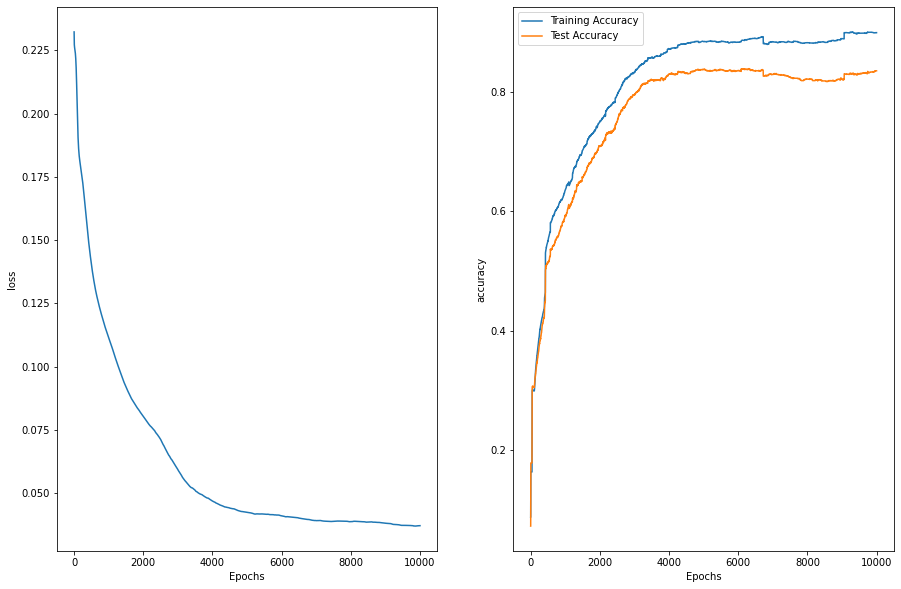

In [18]:
#dimenstions=(nodes_inputlayer,nodes_hidden_layer1,nodes_hidden_layer2, ....., nodes_hidden_layern,nodes_output_layer)
dimenstions=(X_train.shape[1], 16,16, len(np.unique(y_train)))
#activations=(activation_function_of_hidden_layer1,activation_function_of_hidden_layer2, ...., activation_function_of_output_layer )
activations_funct_list= ( Sigmoid, Sigmoid,softmax)
mlp1 = Multilayer_perceptron(total_layer=len(dimenstions),dimensions=dimenstions, activations= activations_funct_list,learning_rate=0.3)
mlp1.fit( X_train,y_OH_train, epochs=10000, display_loss=True,test_data=(X_test,y_OH_test))

# (b) Show some digits that are classified incorrectly.

Incorrectly classfied Digits


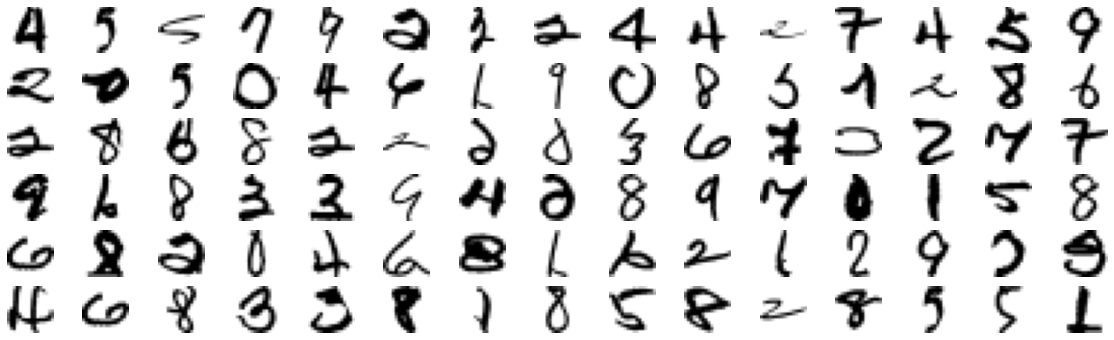

In [10]:
Incorrectly_classfied_images=X_test[Y_pred_test!=y_test]
Incorrectly_classfied_images=scaler.inverse_transform(Incorrectly_classfied_images)
print('Incorrectly classfied Digits')
show_numbers(Incorrectly_classfied_images)

# (c) Plot your first weight layer as a grayscale image.
To scale the weights in range of grayscale image pixel(0,255)
m=(m−rmin)/(rmax−rmin)*(tmax−tmin)+tmin
will scale m linearly into [tmax, tmin] as desired. so here tmax=255, tmin=0 ,rmin  denote the minimum of the range of your weights, rmax denote the maximum of the range of your weights

In [19]:
def show_numbers(X):
    num_samples = X.shape[0]
    print(num_samples)
    indices = np.random.choice(range(len(X)), num_samples)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))
    nu_images=np.round(num_samples/2)
    for i in range(num_samples):
        ax = plt.subplot(2,nu_images, i + 1)
        img = 255 - sample_digits[i].reshape((16, 16))
        plt.imshow(img, cmap='gray')
        plt.axis('off')


16


<ipython-input-19-58b5dc5e4b46>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(2,nu_images, i + 1)


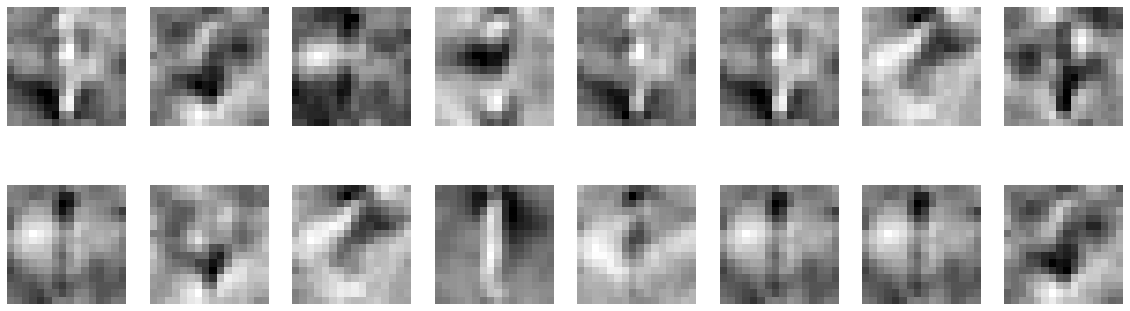

In [20]:
#rescalling values into the grayscale range 0 to 255 
min_value=np.min(mlp.w[1])
max_value=np.max(mlp.w[1])
scaled_value=(mlp.w[1]-min_value)/(max_value-min_value)*255
#plt.imshow(scaled_value.T, cmap="gray") 
#plt.show() 
show_numbers(scaled_value)